# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Effecient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [4]:
# !pip install vit_pytorch
!pip install linformer
!pip install --upgrade tqdm

Requirement already up-to-date: tqdm in /home/jack/anaconda3/lib/python3.8/site-packages (4.62.2)


## Import Libraries

In [5]:
!pip install -e ../.

Obtaining file:///home/jack/vit-pytorch
  Attempting uninstall: vit-pytorch
    Found existing installation: vit-pytorch 0.20.7
    Uninstalling vit-pytorch-0.20.7:
      Successfully uninstalled vit-pytorch-0.20.7
  Running setup.py develop for vit-pytorch


In [ ]:
!pip install -e ../. # install the repo as an editable package in case you want to play with the code

In [1]:
from __future__ import print_function

import glob
from itertools import chain
import os
import randoma
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vitc.early_convolutions import EarlyConvViT

In [2]:
print(f"Torch: {torch.__version__}")

Torch: 1.7.1


In [3]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [7]:
device = 'cuda'

## Load Data

In [8]:
# os.makedirs('data', exist_ok=True)

In [9]:
train_dir = 'data/train'
test_dir = 'data/test'

In [10]:
# # download the data from https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data to /<repo>/examples/
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')

In [11]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [12]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [13]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

## Random Plots

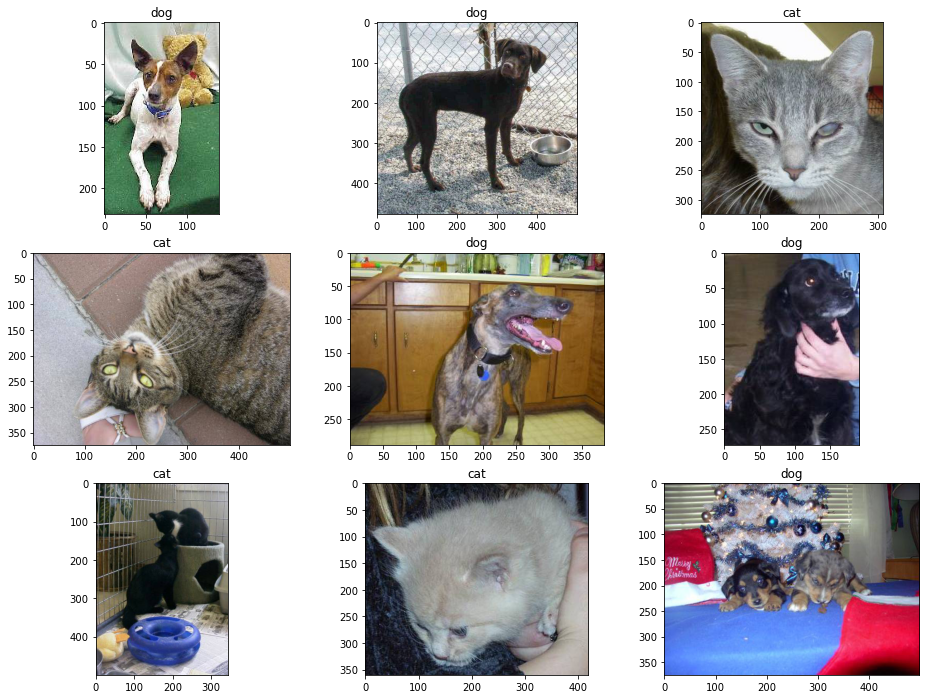

In [14]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [15]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [16]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augumentation

In [17]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [18]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [19]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [20]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [21]:
print(len(train_data), len(train_loader))

20000 313


In [22]:
print(len(valid_data), len(valid_loader))

5000 79


### Visual Transformer

In [27]:
model = EarlyConvViT(
    dim=128,
    num_classes=2,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    channels=3,
).to(device)

### Training

In [28]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [29]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 1 - loss : 0.7029 - acc: 0.4971 - val_loss : 0.6992 - val_acc: 0.5028



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 2 - loss : 0.6969 - acc: 0.4985 - val_loss : 0.6928 - val_acc: 0.5008



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 3 - loss : 0.6955 - acc: 0.5044 - val_loss : 0.6925 - val_acc: 0.5014



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 4 - loss : 0.6931 - acc: 0.5164 - val_loss : 0.6904 - val_acc: 0.5447



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 5 - loss : 0.6883 - acc: 0.5478 - val_loss : 0.6839 - val_acc: 0.5552



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 6 - loss : 0.6726 - acc: 0.5861 - val_loss : 0.6503 - val_acc: 0.6284



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 7 - loss : 0.6616 - acc: 0.6026 - val_loss : 0.6661 - val_acc: 0.5997



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 8 - loss : 0.6526 - acc: 0.6147 - val_loss : 0.6521 - val_acc: 0.6181



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 9 - loss : 0.6451 - acc: 0.6266 - val_loss : 0.6230 - val_acc: 0.6559



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 10 - loss : 0.6370 - acc: 0.6376 - val_loss : 0.6221 - val_acc: 0.6555



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 11 - loss : 0.6263 - acc: 0.6523 - val_loss : 0.6042 - val_acc: 0.6713



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 12 - loss : 0.6138 - acc: 0.6617 - val_loss : 0.5796 - val_acc: 0.6986



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 13 - loss : 0.6085 - acc: 0.6695 - val_loss : 0.5784 - val_acc: 0.7017



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 14 - loss : 0.6065 - acc: 0.6717 - val_loss : 0.5980 - val_acc: 0.6776



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 15 - loss : 0.6038 - acc: 0.6745 - val_loss : 0.5725 - val_acc: 0.7037



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 16 - loss : 0.5992 - acc: 0.6762 - val_loss : 0.5608 - val_acc: 0.7108



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 17 - loss : 0.5926 - acc: 0.6856 - val_loss : 0.5602 - val_acc: 0.7154



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 18 - loss : 0.5956 - acc: 0.6797 - val_loss : 0.5602 - val_acc: 0.7184



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 19 - loss : 0.5888 - acc: 0.6863 - val_loss : 0.5655 - val_acc: 0.7059



  0%|          | 0/313 [00:00<?, ?it/s]

Epoch : 20 - loss : 0.5842 - acc: 0.6921 - val_loss : 0.5473 - val_acc: 0.7239

